In [293]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [214]:
# readinig the clean data
df_location = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Web_Scraping/main/payscale/using_json/data/clean/clean_data_location.csv')
df_employer = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Web_Scraping/main/payscale/using_json/data/clean/clean_data_employer.csv')
df_skills = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Web_Scraping/main/payscale/using_json/data/clean/clean_data_skills.csv')
df_experience = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Web_Scraping/main/payscale/using_json/data/clean/clean_data_experience.csv')
df_summary = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Web_Scraping/main/payscale/using_json/data/clean/clean_data_summary.csv')

---
# EDA on Location

---

In [107]:
df_location

,state,city,job_title,median_salary,profile_count
0,New York,New York,ABAP_Developer,73758.95,10
1,Georgia,Atlanta,ABAP_Developer,80000.00,8
2,Minnesota,Minneapolis,ABAP_Developer,104963.73,5
3,District of Columbia,Washington,ABAP_Developer,67250.00,5
4,Texas,Dallas,ABAP_Developer,105500.00,4
...,...,...,...,...,...
32658,Georgia,Atlanta,Wireless_Communications_Engineer,82424.24,7
32659,California,Santa Clara,Wireless_Communications_Engineer,120000.00,5
32660,California,San Diego,Wireless_Communications_Engineer,97000.00,5
32661,New York,New York,Wireless_Communications_Engineer,85000.00,5


In [89]:
# Generate descriptive table
df_location.describe()

,median_salary,profile_count
count,31302.000000,32663.000000
mean,79471.627573,11.962251
std,34644.256437,27.116447
min,8.170000,2.000000
25%,60500.000000,5.000000
50%,77500.000000,6.000000
75%,99989.730000,10.000000
max,251139.430000,1411.000000


In [209]:
# minimum is 8.17 so these include hourly wages

<Axes: xlabel='median_salary', ylabel='Count'>

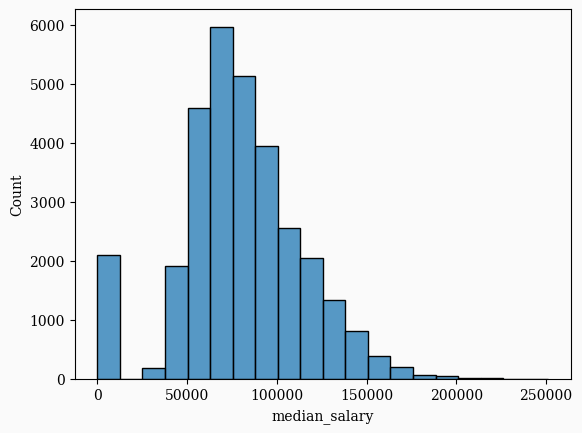

In [215]:
sns.histplot(data=df_location, x='median_salary', bins=20)

In [219]:
# filter out hourly wages
df_location = df_location[(df_location['median_salary'] > 1000)]

<Axes: xlabel='median_salary', ylabel='Count'>

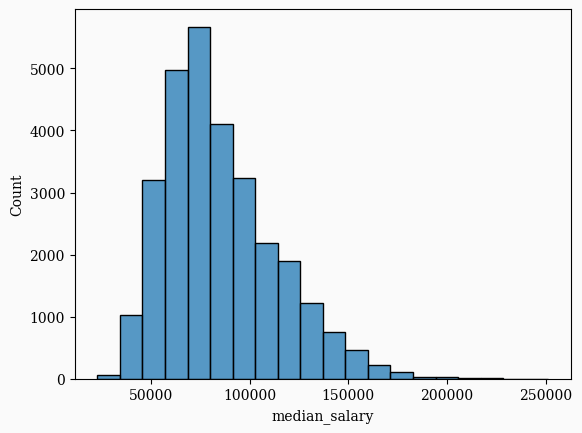

In [220]:
sns.histplot(data=df_location, x='median_salary', bins=20)

In [228]:
print(f'We have {df_location["state"].isnull().sum()} null values in the state column')
print(f'We have {df_location["city"].isnull().sum()} null values in the city column')
print(f'We have {df_location["job_title"].isnull().sum()} null values in the job_title column')
print(f'We have {df_location["median_salary"].isnull().sum()} null values in the median_salary column')
print(f'We have {df_location["profile_count"].isnull().sum()} null values in the profile_count column')

We have 0 null values in the state column
We have 0 null values in the city column
We have 0 null values in the job_title column
We have 0 null values in the median_salary column
We have 0 null values in the profile_count column


In [222]:
# drop those where job_title or median salary is null
df_location = df_location.dropna(subset=['job_title', 'median_salary'])

In [223]:
print(f'We have {df_location["state"].nunique()} unique values in the state column')
print(f'We have {df_location["city"].nunique()} unique values in the city column')
print(f'We have {df_location["job_title"].nunique()} unique values in the job_title column')

We have 51 unique values in the state column
We have 1675 unique values in the city column
We have 492 unique values in the job_title column


In [231]:
print(f'We have {df_location.shape[0]} observations in the data')

We have 28530 observations in the data


In [224]:
# top 10 most frequent job titles
df_location['job_title'].value_counts().reset_index().head(10)

,index,job_title
0,Senior_Software_Engineer,975
1,Information_Technology_(IT)_Manager,857
2,Information_Technology_(IT)_Director,673
3,Web_Developer,486
4,Business_Analyst_IT,458
5,Project_Manager_Information_Technology_(IT),456
6,Database_Administrator_(DBA),424
7,Applications_Engineer,421
8,Network_Engineer,402
9,Network_Engineer_IT,380


In [225]:
# top 10 most frequent cities
df_location['city'].value_counts().reset_index().head(10)

,index,city
0,New York,402
1,Chicago,368
2,Atlanta,332
3,Seattle,331
4,Boston,328
5,Dallas,325
6,Los Angeles,316
7,Washington,314
8,San Francisco,312
9,Houston,306


In [114]:
# top 10 most frequent state
df_location['state'].value_counts().reset_index().head(10)

,index,state
0,California,3621
1,Texas,2063
2,Florida,1705
3,Virginia,1511
4,Pennsylvania,1164
5,New York,1105
6,North Carolina,1066
7,Ohio,1043
8,Michigan,1026
9,Illinois,972


--- 
# Visualizations
--- 


In [294]:
# Preparation for map visualization:
# inspiration and idea by https://towardsdatascience.com/how-to-create-data-maps-of-the-united-states-with-python-and-matplotlib-5dfb425bd87d

def translate_geometries(df, x, y, scale, rotate):
    """
    Translates, scales, and rotates the geometries in the given DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the geometries.
        x (float): The amount to translate the geometries along the x-axis.
        y (float): The amount to translate the geometries along the y-axis.
        scale (float): The scaling factor for the geometries.
        rotate (float): The angle (in degrees) to rotate the geometries.

    Returns:
        pandas.DataFrame: The DataFrame with the translated, scaled, and rotated geometries.
    """
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    """
    Adjusts the maps by translating the geometries of Alaska and Hawaii.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the map data.

    Returns:
    pandas.DataFrame: The adjusted DataFrame with translated geometries for Alaska and Hawaii.
    """
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)
    
    return pd.concat([df_main_land, df_alaska, df_hawaii])

# Load and prepare geo-data
states = gpd.read_file("cb_2018_us_state_500k/")
states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78"])]
states = states.to_crs("ESRI:102003")
states = adjust_maps(states)

edge_color = "#30011E"
background_color = "#fafafa"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})

C:\Users\Peti\AppData\Local\Temp\ipykernel_6616\3576309604.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Peti\AppData\Local\Temp\ipykernel_6616\3576309604.py:18: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\Peti\AppData\Local\Temp\ipykernel_6616\3576309604.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<Axes: >

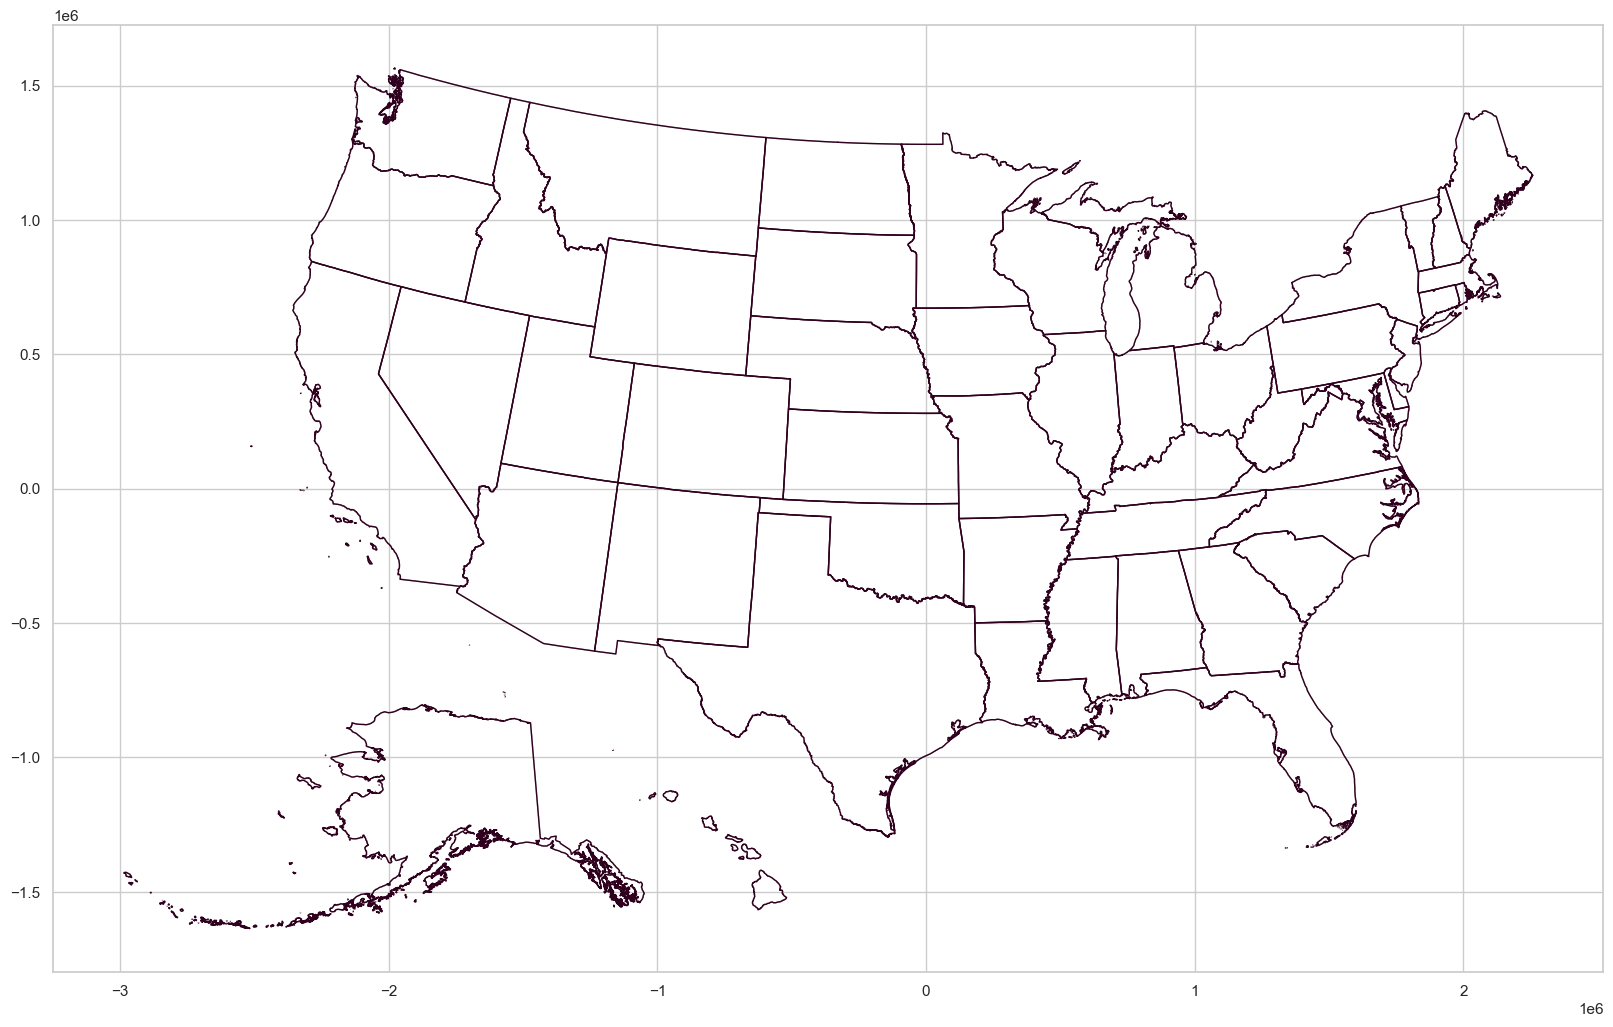

In [510]:
ax = states.plot(edgecolor=edge_color + "55", color="None", figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)


In [296]:
def state_df(df, job_title):
    """
    Create a DataFrame for the map by querying for a specific job title, grouping by state, and aggregating the median salary.

    Parameters:
    df (DataFrame): The input DataFrame containing job data.
    job_title (str): The job title to filter the data.

    Returns:
    DataFrame: The merged DataFrame with state-level median salary information.
    """

    # Query for the job title
    df_state = df.query('job_title == @job_title')

    # Group by state and aggregate the median salary
    df_state = df_state.groupby('state').aggregate({'median_salary':'mean'}).reset_index()

    # Merge the two dataframes
    merged_df = states.merge(df_state, right_on='state', left_on='NAME')

    return merged_df

# create list for job_titles
job_titles = [df_location['job_title'].unique()]
    

In [297]:
job_titles = df_location['job_title'].unique().tolist()
# job_titles

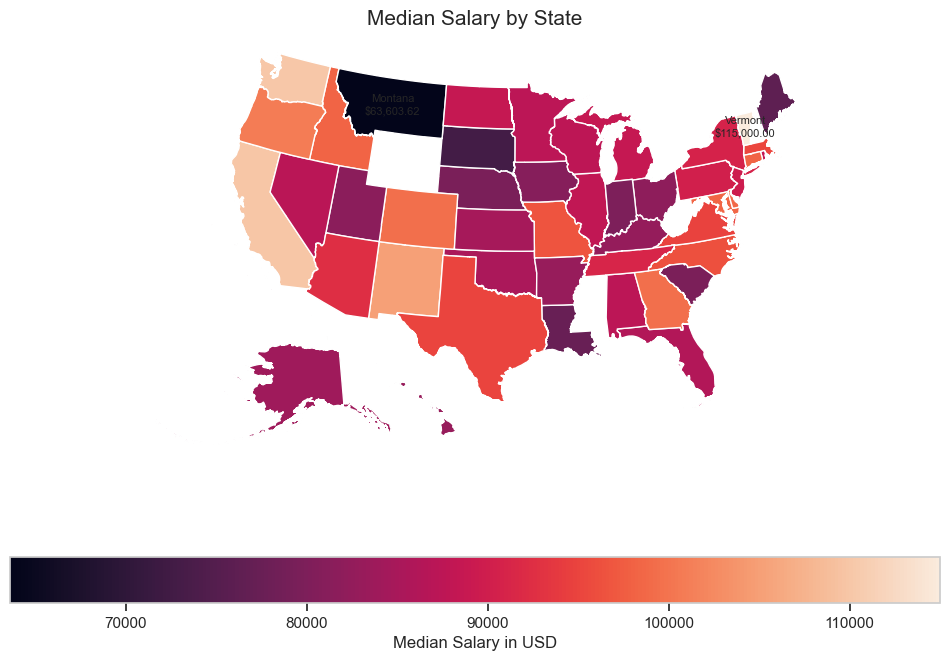

In [513]:
# Plot the map with continuous coloring based on median_salary
fig, ax = plt.subplots(figsize=(12, 8))
merged_df.plot(column='median_salary',ax=ax,legend=True,legend_kwds={'label': "Median Salary in USD",'orientation': "horizontal"},
               vmin=merged_df['median_salary'].min(), vmax=merged_df['median_salary'].max())

# Add title and adjust styling
ax.set_title('Median Salary by State', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()
sns.despine(left=True, bottom=True)

# Find the state with the highest median_salary
highest_salary_state = merged_df.loc[merged_df['median_salary'].idxmax()]

# Find the state with the lowest median_salary
lowest_salary_state = merged_df.loc[merged_df['median_salary'].idxmin()]

# Add state names and median_salary values as annotations for the highest and lowest salary states
for state in [highest_salary_state, lowest_salary_state]:
    x, y = state.geometry.centroid.x, state.geometry.centroid.y
    label, salary = state['state'], state['median_salary']
    ax.text(x, y, f'{label}\n${salary:,.2f}', fontsize=8, ha='center', va='center')
plt.show()

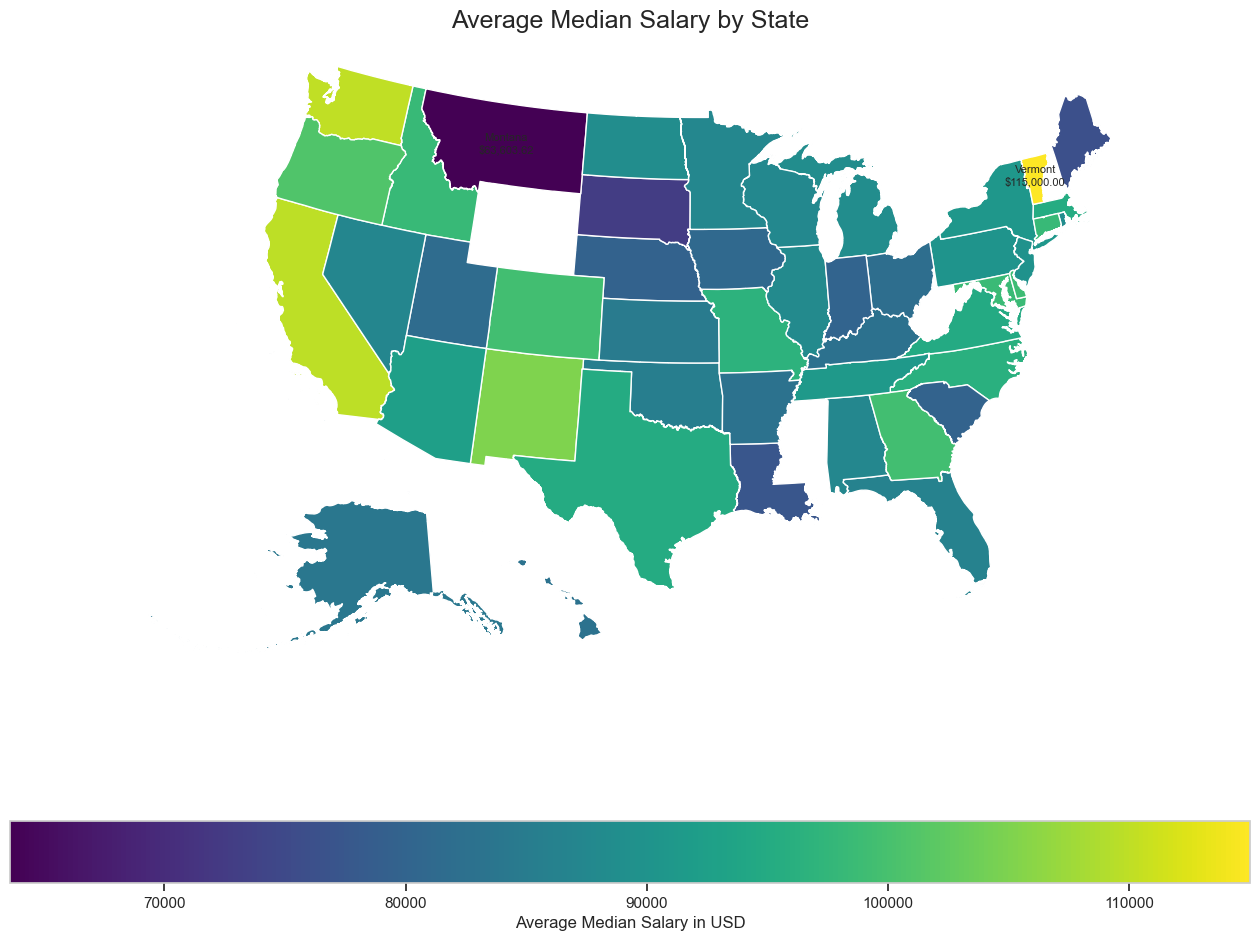

In [522]:
# create DataFrame for the map
merged_df = state_df(df_location,'Data_Scientist')
# Plot the map with continuous coloring based on median_salary
fig, ax = plt.subplots(figsize=(16, 12))
merged_df.plot(column='median_salary',ax=ax,legend=True,cmap= 'viridis',
               legend_kwds={'label': "Average Median Salary in USD",'orientation': "horizontal"},
               vmin=merged_df['median_salary'].min(), vmax=merged_df['median_salary'].max())

# Add title and adjust styling
ax.set_title('Average Median Salary by State', fontdict={'fontsize': '18', 'fontweight' : '3'})
ax.set_axis_off()
sns.despine(left=True, bottom=True)

# Find the state with the highest median_salary
highest_salary_state = merged_df.loc[merged_df['median_salary'].idxmax()]

# Find the state with the lowest median_salary
lowest_salary_state = merged_df.loc[merged_df['median_salary'].idxmin()]

# Add state names and median_salary values as annotations for the highest and lowest salary states
for state in [highest_salary_state, lowest_salary_state]:
    x, y = state.geometry.centroid.x, state.geometry.centroid.y
    label, salary = state['state'], state['median_salary']
    ax.text(x, y, f'{label}\n${salary:,.2f}', fontsize=8, ha='center', va='center')
plt.show()

In [343]:
# create function to create city DataFrame to later be used for highest salary cities
def city_df(df, job_title):
    """
    Create a DataFrame for the map by querying for a specific job title, grouping by city, and aggregating the median salary.

    Parameters:
    df (DataFrame): The input DataFrame containing job data.
    job_title (str): The job title to filter the data.

    Returns:
    DataFrame: The merged DataFrame with city-level median salary information.
    """

    # Query for the job title
    df_city = df.query('job_title == @job_title')

    # Group by city and aggregate the median salary
    df_city = df_city.groupby(['city','state']).aggregate({'median_salary':'mean'}).reset_index()

    return df_city

cities_df = city_df(df_location,'Data_Scientist')


In [344]:
highest_paid_cities = cities_df.sort_values(by='median_salary',ascending=False).head(10)
highest_paid_cities

,city,state,median_salary
264,Stanford,California,154386.03
99,Fort Meade,Maryland,150000.00
147,Livermore,California,148982.25
281,Walnut Creek,California,142431.07
68,Cupertino,California,141157.97
171,Mountain View,California,138889.52
161,Menlo Park,California,138811.13
232,San Mateo,California,134149.68
96,Folsom,California,134129.70
252,South San Francisco,California,132828.48


In [376]:
bar1 = px.bar(highest_paid_cities, x='median_salary', y='city', color='state',
             orientation='h', title='<b>Top 10 Cities with the Highest Average Median Salary<b>',
             template = 'simple_white',
             category_orders={'city': highest_paid_cities.sort_values(by='median_salary', ascending=False)['city'].tolist()},
             labels = {'state' : 'State',})
bar1.update_layout(xaxis_title='',
                   title_x = 0.5,
                   yaxis_title = '',
                   legend=dict(x=1, y=1,font=dict(size=16)) )

bar1.update_layout(height=500, width=1200)

bar1.update_xaxes(range=[0, 160000])

bar1.show()


---
# Analytics on Data Jobs
--- 

In [433]:
# Data jobs in the US
filtered_df_location = df_location[df_location['job_title'].str.contains('Data')]
summary_table = filtered_df_location.groupby('job_title').agg({'median_salary':['count','mean']}).reset_index()
summary_table.columns = [' '.join(col).strip() for col in summary_table.columns.values]
highest_paid_jobs = summary_table.sort_values(by='median_salary mean', ascending=False).head()
highest_paid_jobs

,job_title,median_salary count,median_salary mean
45,Lead_Data_Scientist,29,136678.146552
59,Senior_Data_Scientist,98,128225.123061
57,Senior_Data_Engineer,59,124003.857797
26,Data_Signal_Processing_(DSP)Firmware_Engineer,2,123024.335000
31,Data_Warehouse_Manager,19,121319.918421


In [416]:
highest_profile_numbers = summary_table.sort_values(by='median_salary count', ascending=False).head()
highest_profile_numbers

,job_title,median_salary count,median_salary mean
33,Database_Administrator_(DBA),424,76283.187406
22,Data_Scientist,296,94508.037939
37,Database_Developer,250,75510.959400
13,Data_Engineer,209,91832.994880
36,Database_Architect,136,115786.093676


In [500]:
import plotly.express as px

bar2 = px.bar(highest_paid_jobs, x='median_salary mean', y='job_title',
             orientation='h', title='<b>Top 5 Jobs by Average Median Salary<b>',
             template = 'simple_white',
             category_orders={'job_title': highest_paid_jobs.sort_values(by='median_salary mean', ascending=False)['job_title'].tolist()})

bar2.update_layout(xaxis_title='Median Salary',
                   xaxis = dict(visible=False),
                   title_x = 0.5,
                   yaxis_title = '')

bar2.update_layout(height=500, width=1200)

bar2.update_traces(texttemplate = '%{value:.3s}', textposition='outside') # add data labels outside to the bars

bar2.update_xaxes(range=[0, 160000])

bar2.show()



---
# EDA on Experience
--- 

In [426]:
df_experience

,level,experience,job_title,median_salary,profile_count
0,Entry Level,Less than 1 year,ABAP_Developer,57391.30,5
1,Junior Level,1-4 years,ABAP_Developer,72696.54,10
2,Mid Level,5-9 years,ABAP_Developer,95595.10,17
3,Senior Level,10-19 years,ABAP_Developer,111411.79,14
4,Executive Level,20 years or more,ABAP_Developer,101119.65,14
...,...,...,...,...,...
2641,Senior Level,10-19 years,Wireless_Communications_Engineer,101791.67,17
2642,Executive Level,20 years or more,Wireless_Communications_Engineer,92000.00,15
2643,Junior Level,1-4 years,Wireless_Network_Optimization_Engineer,65000.00,8
2644,Mid Level,5-9 years,Wireless_Network_Optimization_Engineer,72000.00,8


In [421]:
# Generate descriptive table
df_experience.describe()

,median_salary,profile_count
count,2400.000000,2400.000000
mean,88271.157279,165.820000
std,27280.352630,546.341524
min,30000.000000,2.000000
25%,67479.577500,10.000000
50%,83228.655000,29.000000
75%,105864.520000,101.000000
max,198214.410000,11834.000000


<Axes: xlabel='median_salary', ylabel='Count'>

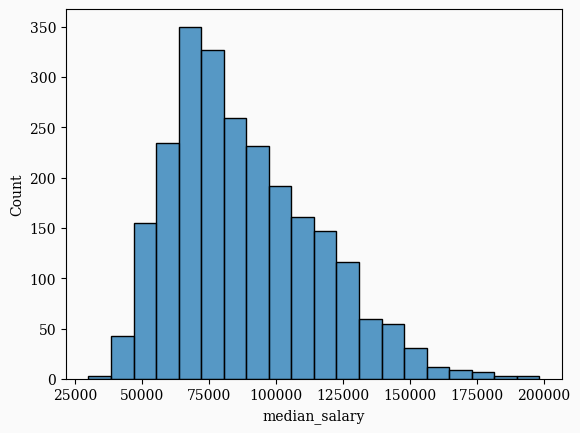

In [420]:
# hourly salary is also present here
# filter them out
df_experience = df_experience[(df_experience['median_salary'] > 1000)]
sns.histplot(data=df_experience, x='median_salary', bins=20)

In [423]:
print(f'We have {df_experience["level"].isnull().sum()} null values in the state column')
print(f'We have {df_experience["experience"].isnull().sum()} null values in the city column')
print(f'We have {df_experience["job_title"].isnull().sum()} null values in the job_title column')
print(f'We have {df_experience["median_salary"].isnull().sum()} null values in the median_salary column')
print(f'We have {df_experience["profile_count"].isnull().sum()} null values in the profile_count column')

We have 0 null values in the state column
We have 0 null values in the city column
We have 35 null values in the job_title column
We have 0 null values in the median_salary column
We have 0 null values in the profile_count column


In [428]:
# drop those where job_title or median salary is null
df_location = df_location.dropna(subset='median_salary')

In [430]:
print(f'We have {df_experience["job_title"].nunique()} unique values in the job_title column')

We have 577 unique values in the job_title column


In [467]:
filtered_df_experience = df_experience[df_experience['job_title'].str.contains('Data_Scientist') & df_experience['job_title'].notna()]
filtered_df_experience

,level,experience,job_title,median_salary,profile_count
148,Entry Level,Less than 1 year,Associate_Data_Scientist,76784.53,73
149,Junior Level,1-4 years,Associate_Data_Scientist,81247.93,298
150,Mid Level,5-9 years,Associate_Data_Scientist,100172.97,9
705,Entry Level,Less than 1 year,Data_Scientist,86648.92,1313
706,Junior Level,1-4 years,Data_Scientist,98292.54,7597
707,Mid Level,5-9 years,Data_Scientist,113768.55,2459
708,Senior Level,10-19 years,Data_Scientist,125128.28,651
709,Executive Level,20 years or more,Data_Scientist,135899.94,138
710,Entry Level,Less than 1 year,Data_Scientist__Engineer,78564.92,12
711,Junior Level,1-4 years,Data_Scientist__Engineer,83211.73,46


C:\Users\Peti\AppData\Local\Temp\ipykernel_6616\1437556834.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



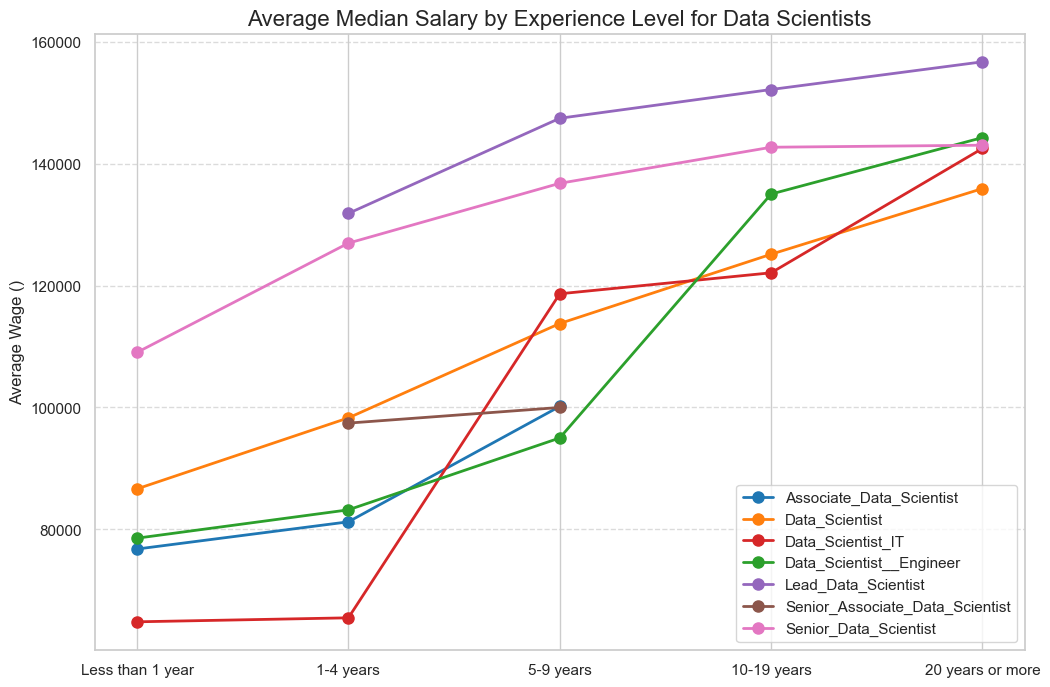

In [471]:
# Create a color map based on job_title
unique_job_titles = filtered_df_experience['job_title'].unique()
color_map = {job_title: plt.cm.get_cmap('tab10')(i) for i, job_title in enumerate(unique_job_titles)}

plt.figure(figsize=(12, 8))
for job_title, group in filtered_df_experience.groupby('job_title'):
    plt.plot(group['experience'], group['median_salary'], marker='o', label=job_title, color=color_map[job_title], linestyle='-', linewidth=2, markersize=8)

# Adding labels and title
plt.title(f'Average Median Salary by Experience Level for Data Scientists', fontsize=16)
plt.xlabel('')
plt.ylabel('Average Wage ()')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.show()


--- 
# Employer 
--- 

look at Data Scientists

In [475]:
filtered_df_employer = df_employer[df_employer['job_title'].str.contains('Data_Scientist') & df_employer['job_title'].notna()]
filtered_df_employer

,name,job_title,median_salary,profile_count
359,National Registry of EMTs,Associate_Data_Scientist,70328.18,6
360,"Biomerieux, Inc.",Associate_Data_Scientist,61041.89,5
1432,"Booz, Allen, and Hamilton",Data_Scientist,88137.02,168
1433,Facebook Inc,Data_Scientist,124133.48,66
1434,Amazon.com Inc,Data_Scientist,130841.25,45
...,...,...,...,...
4909,Facebook Inc,Senior_Data_Scientist,151695.55,5
4910,Cox Enterprises,Senior_Data_Scientist,131607.29,5
4911,Capital One Financial Corp,Senior_Data_Scientist,129060.38,5
4912,3M Company,Senior_Data_Scientist,122320.67,5


In [477]:
filtered_df_employer['job_title'].value_counts()

Data_Scientist              247
Senior_Data_Scientist        44
Lead_Data_Scientist           5
Data_Scientist_IT             4
Associate_Data_Scientist      2
Name: job_title, dtype: int64

In [480]:
filtered_df_employer['name'].value_counts()

Booz, Allen, and Hamilton                      4
Humana, Inc.                                   3
Microsoft Corp                                 3
International Business Machines (IBM) Corp.    3
Caterpillar, Inc.                              3
                                              ..
ICF International                              1
HCL America, Inc.                              1
MasterCard Worldwide                           1
Lockheed Martin Corp                           1
Ascension Health                               1
Name: name, Length: 258, dtype: int64

In [491]:
ds_df = filtered_df_employer[filtered_df_employer['job_title'] == 'Data_Scientist']
ds_df = ds_df.sort_values(by='median_salary', ascending=False).head(10)
ds_df

,name,job_title,median_salary,profile_count
1576,Peraton,Data_Scientist,151750.00,6
1632,Applied Materials Inc,Data_Scientist,144000.00,5
1544,GlaxoSmithKline,Data_Scientist,141438.41,7
1488,"Genentech, Inc.",Data_Scientist,140000.00,11
1599,GrubHub,Data_Scientist,137568.93,6
1604,"iHeartMedia, Inc",Data_Scientist,137500.00,6
1592,Ancestry.com,Data_Scientist,134994.00,6
1549,"Aetna, Inc.",Data_Scientist,134545.36,7
1443,"Google, Inc.",Data_Scientist,134518.03,24
1504,The Walt Disney Company,Data_Scientist,131639.20,10


In [507]:
bar3 = px.bar(ds_df, x='median_salary', y='name',color = 'profile_count',
             orientation='h', title='<b>Top 10 Companies with the Highest Average Median Salary for Data Scientists<b>',
             template = 'simple_white',
             color_continuous_midpoint=12,
             category_orders={'name': ds_df['name'].tolist()})

bar3.update_layout(xaxis_title='',
                   title_x = 0.5,
                   yaxis_title = '',
                   legend=dict(x=1, y=1,font=dict(size=16)) )

bar3.update_layout(height=500, width=1200)

bar3.update_xaxes(range=[0, 160000])

bar3.show()
